<a href="https://colab.research.google.com/github/alekart30/RecSys/blob/master/RecSys1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All imports

In [0]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

In [0]:
%matplotlib inline
sns.set_style('darkgrid')

# Load data

In [93]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1b7bL--KJ5fc-n26b0BrJhtjZGj8gslqw', dest_path='./data/movies.zip')

In [94]:
! unzip ./data/movies.zip -d ./data/unziped

Archive:  ./data/movies.zip
   creating: ./data/unziped/ml-20m/
  inflating: ./data/unziped/ml-20m/genome-scores.csv  
  inflating: ./data/unziped/ml-20m/genome-tags.csv  
  inflating: ./data/unziped/ml-20m/links.csv  
  inflating: ./data/unziped/ml-20m/movies.csv  
  inflating: ./data/unziped/ml-20m/ratings.csv  
  inflating: ./data/unziped/ml-20m/README.txt  
  inflating: ./data/unziped/ml-20m/tags.csv  


# EDA

We have 6 tables.

This table contains all info about user - movie interaction by ratings.

In [95]:
ratings_df = pd.read_csv('./data/unziped/ml-20m/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [96]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


Luckily no nans

In [97]:
ratings_df.isnull().values.any()

False

Total number of users

In [98]:
ratings_df['userId'].nunique()

138493

Total number of ratings is:

In [99]:
ratings_df.shape[0]

20000263

Total number of movies is:

In [100]:
ratings_df['movieId'].nunique()

26744

Al least 20 ratings were made by one user. Very active user made 9254 ratings.

In [101]:
ratings_df.groupby('userId').agg({'rating' : 'count'}).describe()

,rating
count,138493.000000
mean,144.413530
std,230.267257
min,20.000000
25%,35.000000
50%,68.000000
75%,155.000000
max,9254.000000


Text(0.5, 0, 'number of ratings')

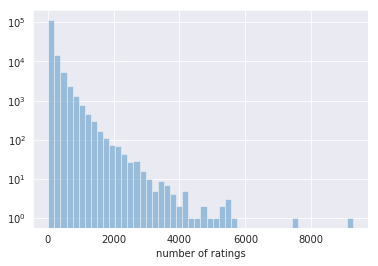

In [102]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.distplot(ratings_df.groupby('userId').agg({'rating' : 'count'}).values, ax=ax, kde=False)
ax.set_yscale('log')
ax.set_xlabel("number of ratings")

Ratings distribution

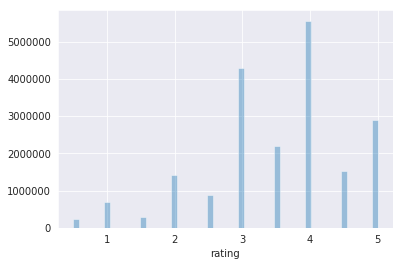

In [103]:
sns.distplot(ratings_df['rating'],kde=False)

We can see that ratings are ordinal, not numerical. Fraction ratings are less popular than integer. 

Our user - item interaction matrix is very sparse. Less than a percent of all cells is filled.

In [104]:
ratings_df.shape[0] / (ratings_df['userId'].nunique() * ratings_df['movieId'].nunique())

0.0053998478135544505

All tags contain in this table.

In [105]:
tags_df = pd.read_csv('./data/unziped/ml-20m/tags.csv')
tags_df.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


Luckily no nans.

In [55]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
userId       465564 non-null int64
movieId      465564 non-null int64
tag          465548 non-null object
timestamp    465564 non-null int64
dtypes: int64(3), object(1)
memory usage: 14.2+ MB


Total number of unique tags.

In [56]:
tags_df['tag'].nunique()

38643

At least user added one tag. Extremly active - 20356 tags.  

In [59]:
tags_df.groupby('userId').agg({'tag':'count'}).describe()

,tag
count,7801.000000
mean,59.677990
std,414.804435
min,1.000000
25%,2.000000
50%,4.000000
75%,20.000000
max,20356.000000


Text(0.5, 0, 'number of tags')

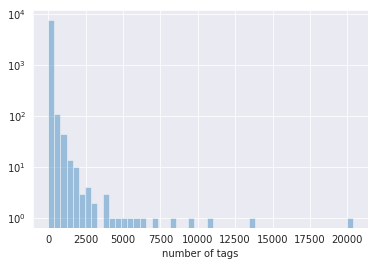

In [61]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.distplot(tags_df.groupby('userId').agg({'tag' : 'count'}).values, ax=ax, kde=False)
ax.set_yscale('log')
ax.set_xlabel("number of tags")

Tables which left

In [62]:
genome_tags_df = pd.read_csv('./data/unziped/ml-20m/genome-tags.csv')
genome_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [64]:
genome_scores_df = pd.read_csv('./data/unziped/ml-20m/genome-scores.csv')
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [65]:
movies_df = pd.read_csv('./data/unziped/ml-20m/movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [66]:
links_df = pd.read_csv('./data/unziped/ml-20m/links.csv')
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


# Evaluation metrics implementation

In [0]:
def precision_at_k(predicted, actual, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(actual)
  return len(intersection) / k

In [0]:
def average_precision(predicted, actual):
  tmp = 0
  actual_length = min(len(actual), len(predicted))
  for i in range(actual_length):
    if predicted[i] in actual:
      tmp += precision_at_k(predicted[:i+1], actual, i+1)
  return tmp / actual_length

In [0]:
predicted = [1,3,5,2,13,9,10,17]
actual = [1,3,2,5,4,8,9,10]


In [150]:
precision_at_k(predicted, actual, k=8)

0.75

In [151]:
average_precision(predicted, actual)

0.7113095238095237

In [0]:
def mean_average_precision(y_pred, y_actual):
  return sum(average_precision(predicted, actual) for predicted, actual in zip(y_pred, y_actual)) / len(y_pred)
    

In [157]:
mean_average_precision([predicted, predicted], [actual, actual])

0.7113095238095237

In [0]:
def mean_percentage_ranking(predicted, actual):
  pass

# Collaborative filtering recommenders

In [0]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'])

In [109]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1970-01-01 00:00:01.112486027
1,1,29,3.5,1970-01-01 00:00:01.112484676
2,1,32,3.5,1970-01-01 00:00:01.112484819
3,1,47,3.5,1970-01-01 00:00:01.112484727
4,1,50,3.5,1970-01-01 00:00:01.112484580


In [0]:
##CAN'T MAKE ONE SIMPLE TRAIN TEST SPLIT!!!!!
tscv = TimeSeriesSplit(n_splits=2)
X_train, X_test, y_train, y_test = None, None, None, None
for train_index, test_index in tscv.split(ratings_df):
  X_train, X_test = ratings_df.loc[train_index,['userId', 'movieId']], ratings_df.loc[test_index, ['userId', 'movieId']]
  y_train, y_test = ratings_df.loc[train_index, 'rating'], ratings_df.loc[test_index, 'rating']

In [129]:
 X_train['rating'] = y_train
 list(X_train.groupby('movieId').agg({'userId' : 'count'}).sort_values(by='userId', ascending=False)[:5].index)

[296, 356, 318, 593, 480]

In [0]:
class MostPopularRecommender():
  def __init__(self, top_n=5):
    self.top_n = top_n
  
  def fit(self, X_train, y_train):
    assert type(X_train) == pd.DataFrame
    self.most_popular = list(X_train.groupby('movieId').agg({'userId' : 'count'}).sort_values(by='userId', ascending=False)[:5].index)
  
  def predict(self, X_test):
    return [self.most_popular] * X_test.shape[0]

In [0]:
most_popular_recommender = MostPopularRecommender(top_n=5)
most_popular_recommender.fit(X_train, y_train)
y_pred = most_popular_recommender.predict(X_test)

In [137]:
y_pred

[[296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593, 480],
 [296, 356, 318, 593